Notice: Cada amostra da base de dados apresenta apenas um tipo defeito dentre Desalinhamento, Desbalanceamentos horizontal e vertical. Cada um será analisado separadamente.

### Objetivo 
Encontar o melhor modelo para regressão da severidade do **Desbalanceamento**

In [1]:
import pandas as pd

#biliotecas para extração e visualização do FFT ou Periodogram (PSD) 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aux_functions as aux   # biblioteca particular em arquivo anexo

sns.set_theme()

In [2]:
df = pd.read_csv('../data.csv')

# separa apenas amostras com defeito de DESBALANCEAMENTO
df =  df.query("defeito == 'desbalanceamento' or defeito == 'normal'")
# descarta a coluna 'defeito', pois é agora informação redundante
df.pop('defeito')


# adiciona a feature 1/fundamental
fundamental_inverse = df['fundamental'].apply(lambda x: 1/x)
df.insert(4, 'fund_inverse', fundamental_inverse)


# exibe fragmento dos dados
df.iloc[:,:6].head()

,severidade,rotacao,fundamental,ax1_1h,fund_inverse,ax1_2h
498,10.0,13.9264,13.6272,6.966357,0.073383,0.510580
499,10.0,14.5408,14.2284,5.608414,0.070282,0.487584
500,10.0,15.7696,15.4308,4.343829,0.064805,2.574365
501,10.0,16.5888,16.2324,5.357364,0.061605,2.606845
502,10.0,17.2032,16.8336,4.905962,0.059405,1.965951


O valor 'fundamental' extraído do tacômetro representa melhor a velocidade do rotor do que o valor fornecido pela base. Por isso, dispensamos o último com `df.pop('rotacao')`

In [3]:
df.pop('rotacao');

# Desbalanceamento <a class="anchor" id="desbalanceamento"></a>

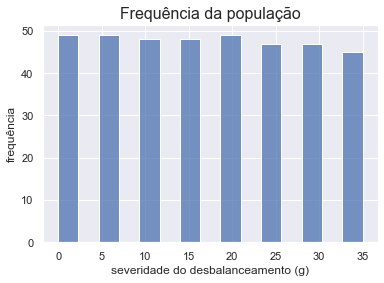

In [4]:
# armazena output em um array
output = np.array(df['severidade'])

# plota distribuição da população
sns.histplot(output, bins=15)
plt.title('Frequência da população', fontsize=16)
plt.xlabel('severidade do desbalanceamento (g)')
plt.ylabel('frequência')
plt.show()

Dada a consideração 1, os dados de treino e teste possuem sempre muitos dados com 'defeito' = 0

In [5]:
# remove a coluna de outputs do df original
df.pop('severidade')

# salva a ordem das features
feature_list = list(df)

# converte df para array
data = np.array(df)

In [6]:
df.head()

,fundamental,ax1_1h,fund_inverse,ax1_2h,ax1_3h,ax1_entr,ax1_kurt,ax1_mean,ax1_rms,ax2_1h,...,tg1_kurt,tg1_mean,tg1_rms,tg2_1h,tg2_2h,tg2_3h,tg2_entr,tg2_kurt,tg2_mean,tg2_rms
498,13.6272,6.966357,0.073383,0.510580,5.082876,3.063727,-0.886690,0.032697,87.310458,3.660366,...,-0.270437,0.001106,3.332768,15.480691,7.594987,2.650111,2.635456,-0.142961,0.039913,48.052180
499,14.2284,5.608414,0.070282,0.487584,6.771639,3.049969,-0.932425,0.031285,86.015864,3.133558,...,-0.163261,0.001154,3.388859,14.169379,7.455570,2.611577,2.711809,-0.293248,-0.019935,51.543861
500,15.4308,4.343829,0.064805,2.574365,30.017157,2.884913,-0.861553,-0.009577,73.196936,3.094011,...,-0.056329,-0.000269,3.841905,9.420763,5.237704,1.671434,2.673544,-0.265470,0.116550,50.609899
501,16.2324,5.357364,0.061605,2.606845,39.454727,2.780495,-0.823096,0.025364,63.387665,3.847720,...,-0.167401,0.002180,3.830312,11.122514,3.149082,2.196249,2.572040,-0.364828,0.081646,45.340454
502,16.8336,4.905962,0.059405,1.965951,23.055039,2.871253,-0.867789,0.012506,70.861639,2.812728,...,-0.006069,0.000525,4.325995,10.391749,3.257844,1.170166,3.550595,-0.724785,-0.061868,127.442876


### Avaliando modelos com K-Fold Crossvalidation

In [7]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GroupKFold, StratifiedKFold

# kfold =           KFold(n_splits=8, shuffle=True, random_state=42)
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

In [8]:
# encontra o melhor alpha para a regressão Ridge
from sklearn.linear_model import LassoLarsCV
reg = LassoLarsCV(cv=5).fit(data, output)
reg.alpha_

0.005669511694796604

In [9]:
# encontra o melhor alpha para a regressão Lasso

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import sklearn.metrics as metrics

modelos = [
    LinearRegression(),
    # Ridge(alpha=0.1),
    # Lasso(alpha=0.00567),
    # Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    #           ('linear lasso', Lasso(alpha=0.00567))         ]),
    make_pipeline(StandardScaler(), 
                  SVR() ),
    KNeighborsRegressor(n_neighbors=3),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators= 10, random_state=42),
]

id_modelos = [
    'Regressão linear',
    # 'Regressão Ridge',
    # 'Lasso',
    # 'Linear Lasso Polinomial',
    'SVR',
    'KNN Regressor',
    'Árvore de decisão regressora',
    'Floresta aleatória regressora',
]

In [11]:
# usando cross-validation
resultados=[]
for modelo in modelos:
    result = cross_val_score(modelo, data, output, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)
    resultados.append(result)

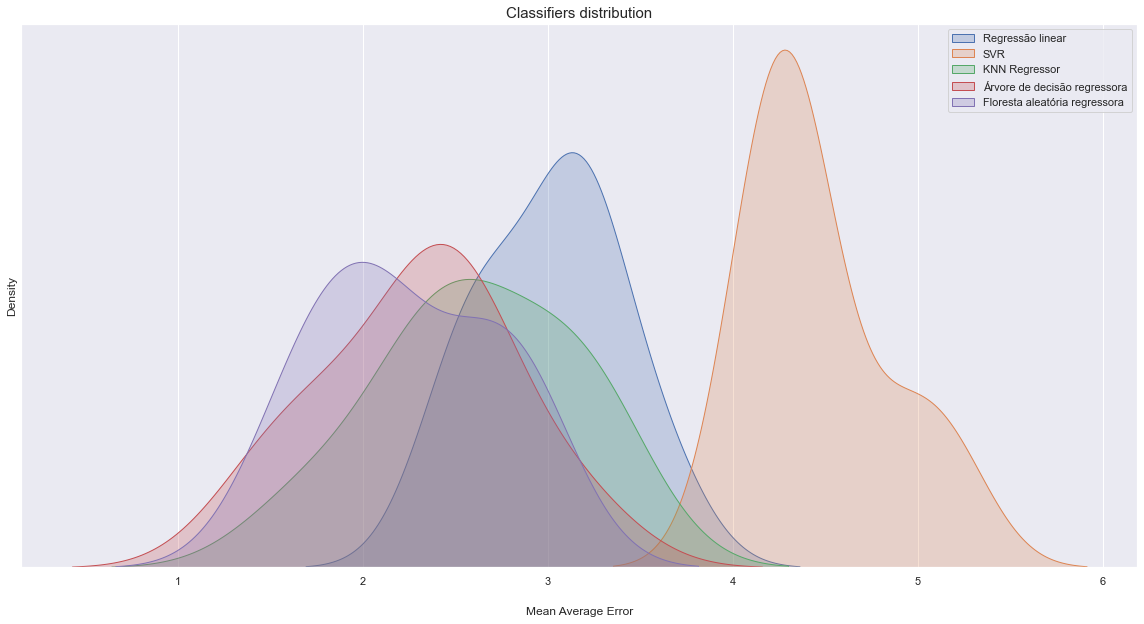

In [12]:
plt.figure(figsize=(20, 10))
for i, modelo in enumerate(id_modelos):
    sns.distplot(-resultados[i], hist=False, kde_kws={"shade": True})

plt.title("Classifiers distribution", fontsize=15)
plt.legend(id_modelos)
plt.xlabel("Mean Average Error", labelpad=20)
plt.yticks([])

plt.show()

### Visualizando modelos com Train-Test Split

Text(0, 0.5, 'frequência')

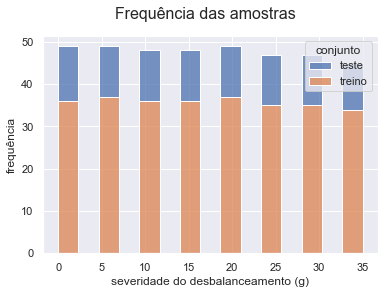

In [24]:
from sklearn.model_selection import train_test_split

# separa os conjuntos de treino e teste com amostragem estratificada,
# logo, mantendo a proporção para cada tipo de defeito
X_train, X_test, y_train, y_test = train_test_split(data, output, test_size = 0.25, stratify=output, random_state=42) 

output_amostrado = pd.DataFrame( {'severidade': np.concatenate((y_test, y_train)),
                                  'fundamental': np.concatenate((X_test[:,0], X_train[:,0])),
                                  'conjunto': ['teste']*len(y_test) + ['treino']*len(y_train)} )

sns.histplot(output_amostrado, x='severidade', stat="count", multiple="stack", hue='conjunto', bins=15)
plt.suptitle('Frequência das amostras', fontsize=16)
plt.xlabel('severidade do desbalanceamento (g)')
plt.ylabel('frequência')

# sns.jointplot(data=output_amostrado, x='severidade', y='fundamental', hue='conjunto',
#                 kind='hist', bins=30, marginal_ticks=True, marginal_kws=dict(bins=15, fill=False, multiple="stack"));

In [14]:
resultados = [None]*len(id_modelos)
metricas = pd.DataFrame()

for i, item in enumerate(id_modelos):
    # treina os modelos com dados de treino
    modelos[i].fit(X_train, y_train)

    # prevê com o modelo a partir do conjunto de teste
    y_predicted = modelos[i].predict(X_test)

    # salva DataFrame com resultados
    resultados[i] = aux.gera_df_resultados(X_test, feature_list, y_predicted, y_test)

    # salva métricas com o desempenho do modelo
    metricas = pd.concat([ metricas, aux.gera_df_metricas(y_predicted, y_test, item) ], ignore_index=True)

metricas

,modelo,R2,MSE,RMSE,MAE
0,Regressão linear,0.882549,15.056363,3.880253,2.987603
1,SVR,0.691955,39.489131,6.284038,4.619292
2,KNN Regressor,0.792864,26.553241,5.152984,2.687500
3,Árvore de decisão regressora,0.850242,19.197917,4.381543,1.656250
4,Floresta aleatória regressora,0.855135,18.570625,4.309365,2.231250


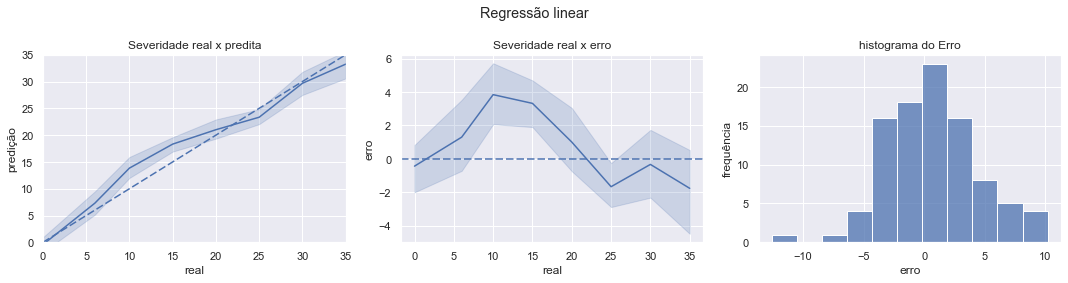

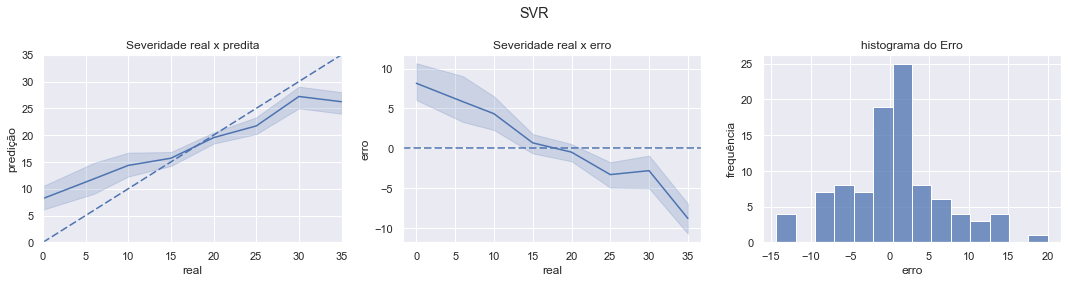

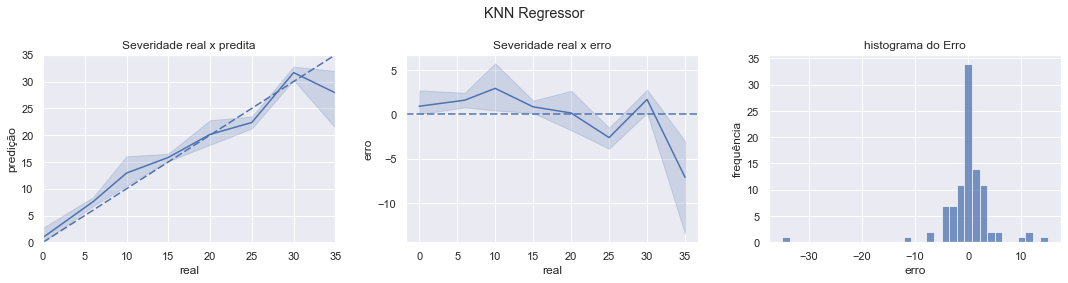

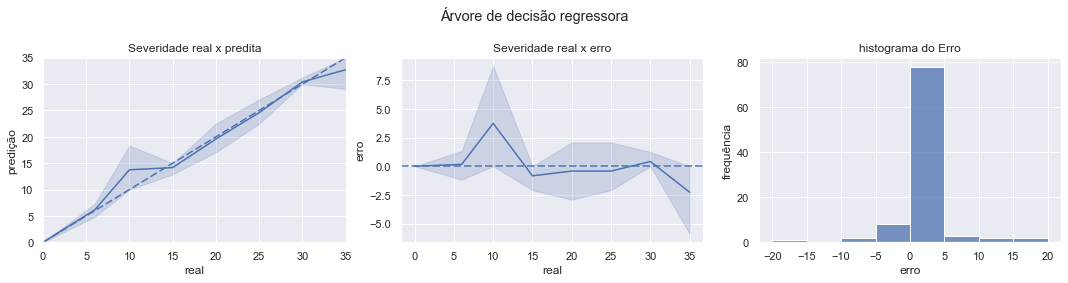

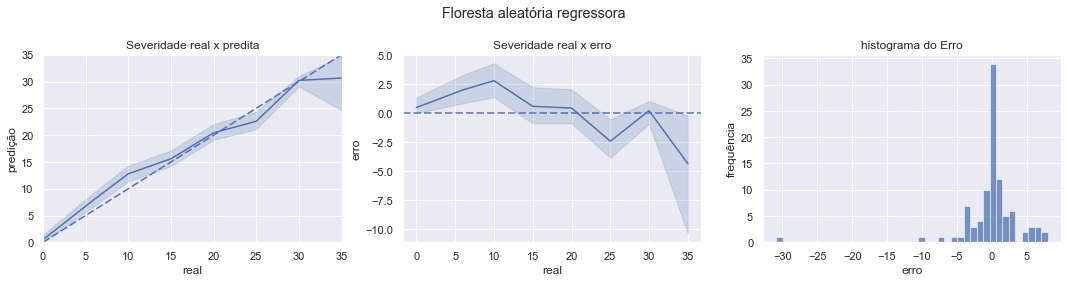

In [15]:
for i, item in enumerate(id_modelos):
    aux.plota_resultados(resultados[i], item, 'desbalanceamento')

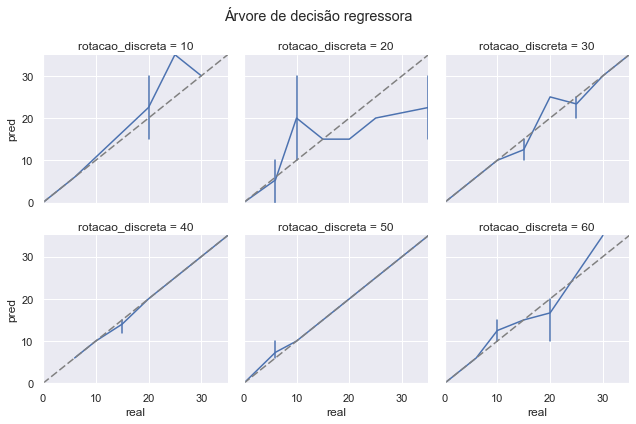

In [16]:
aux.plota_resultados_segregados(resultados[3], id_modelos[3], 'desbalanceamento')

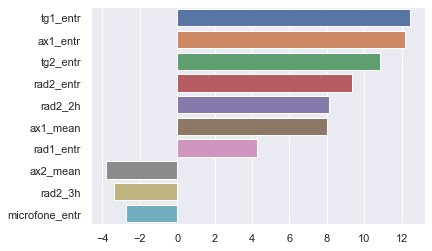

In [17]:
linear_regression = Ridge(alpha=0.1).fit(X_train, y_train)
coeficientes = pd.Series(linear_regression.coef_, index=feature_list)
coeficientes = coeficientes[coeficientes.abs().sort_values(ascending=False)[:10].index]
g = sns.barplot(y=coeficientes.index, x=coeficientes, orient='h')
# g.set_xticklabels(g.get_xticklabels(), rotation=90);

### Conclusão
?

# TPOT <a class="anchor" id="TPOT"></a>
TPOT é um algoritmo Auto_ML, que gera o modelo otimizado após testes exaustivos.

In [18]:
# a reexecução do TPOT pode levar horas, dias..

# from tpot import TPOTRegressor
# pipeline_optimizer_hor_mis = TPOTRegressor()
# pipeline_optimizer_hor_mis.fit(train_data, train_labels[:,0])

In [19]:
#  print(pipeline_optimizer_hor_mis.score(test_data, test_labels[:,0]))
#  pipeline_optimizer_hor_mis.export('tpot_pipeline_hor_mis.py')

### Modelo gerado pelo TPOT (após 1 dia de busca)

In [20]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from tpot.builtins import StackingEstimator

# Average CV score on the training set was: -0.009330433709391846
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    StackingEstimator(estimator=AdaBoostRegressor(learning_rate=1.0, loss="exponential", n_estimators=100)),
    RandomForestRegressor(bootstrap=False, max_features=0.4, min_samples_leaf=4, min_samples_split=16, n_estimators=100)
)


exported_pipeline.fit(X_train, y_train)
y_predicted = exported_pipeline.predict(X_test)


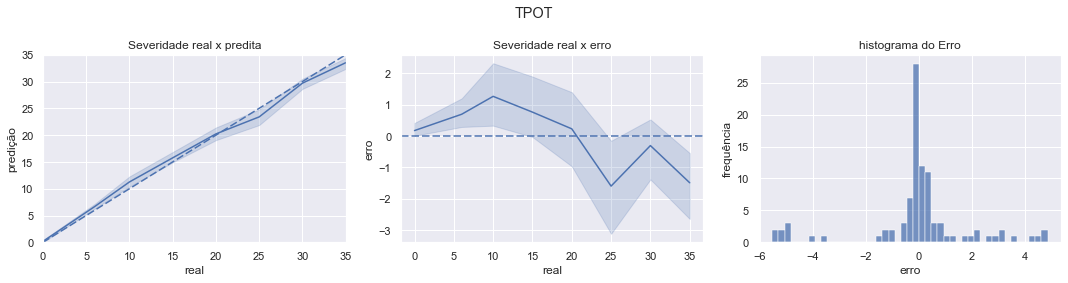

In [21]:
resultados_TPOT = aux.gera_df_resultados(X_test, feature_list, y_predicted, y_test)

aux.plota_resultados(resultados_TPOT, 'TPOT','desbalanceamento')

In [22]:
metricas = pd.concat([ metricas, aux.gera_df_metricas(y_predicted, y_test, 'TPOT') ], ignore_index=True)
metricas.head()

,modelo,R2,MSE,RMSE,MAE
0,Regressão linear,0.882549,15.056363,3.880253,2.987603
1,SVR,0.691955,39.489131,6.284038,4.619292
2,KNN Regressor,0.792864,26.553241,5.152984,2.687500
3,Árvore de decisão regressora,0.850242,19.197917,4.381543,1.656250
4,Floresta aleatória regressora,0.855135,18.570625,4.309365,2.231250


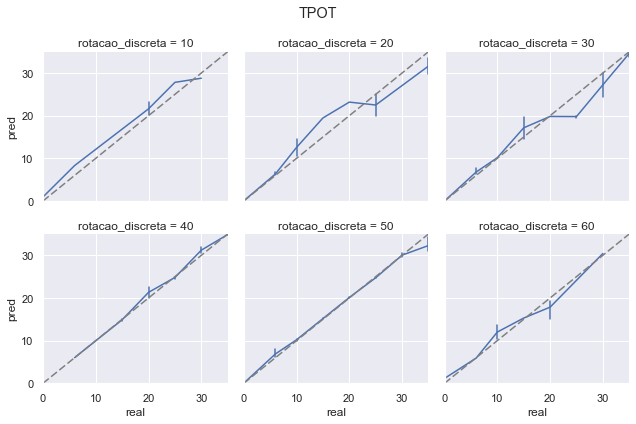

In [23]:
aux.plota_resultados_segregados(resultados_TPOT, 'TPOT', 'desbalanceamento')